# Kaggle Catigorical Data Binary Classification

Predicting the probability [0, 1] of a binary target column.

The data contains binary features (bin_*), nominal features (nom_*), ordinal features (ord_*) as well as (potentially cyclical) day (of the week) and month features. The string ordinal features ord_{3-5} are lexically ordered according to string.ascii_letters.

Since the purpose of this competition is to explore various encoding strategies, the data has been simplified in that (1) there are no missing values, and (2) the test set does not contain any unseen feature values (See this). (Of course, in real-world settings both of these factors are often important to consider!)

Files
 - train.csv - the training set
 - test.csv - the test set; you must make predictions against this data
 - sample_submission.csv - a sample submission file in the correct format

ToC:
 - Imports
 - Load Data
 - EDA
    - Target Distribution
    - Explore NANs
    - Check column types
    - Check unique values
 - Encode categotical variables
 - Explore nom_0 - ord_5 cols
 - Frequency encoding
    - Check correlations
 - Label encoding
 - Baseline models
    - Logistic regression
    - Random Forest
 - Feature engeneering
    - Cyclical features
    - One-hot encoding
    - Target encoding
 - Logistic regression
 - Random Forest
 - Grid search
 - Logreg CV
 - submission

## Imports

In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder

import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [2]:
train_df = pd.read_csv('/Users/alex/Documents/cat-in-the-dat/train.csv')
test_df = pd.read_csv('/Users/alex/Documents/cat-in-the-dat/test.csv')
print('Training data shape:', train_df.shape)
print('Testing data shape:', test_df.shape)
test_df.head()

Training data shape: (300000, 25)
Testing data shape: (200000, 24)


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,300000,0,0,1,T,Y,Blue,Triangle,Axolotl,Finland,...,9d117320c,3c49b42b8,2,Novice,Warm,j,P,be,5,11
1,300001,0,0,0,T,N,Red,Square,Lion,Canada,...,46ae3059c,285771075,1,Master,Lava Hot,l,A,RP,7,5
2,300002,1,0,1,F,Y,Blue,Square,Dog,China,...,b759e21f0,6f323c53f,2,Expert,Freezing,a,G,tP,1,12
3,300003,0,0,1,T,Y,Red,Star,Cat,China,...,0b6ec68ff,b5de3dcc4,1,Contributor,Lava Hot,b,Q,ke,2,3
4,300004,0,1,1,F,N,Red,Trapezoid,Dog,China,...,f91f3b1ee,967cfa9c9,3,Grandmaster,Lava Hot,l,W,qK,4,11


## EDA

### Check target distributuon

In [3]:
# check binary target data distribution
train_df['target'].value_counts()/len(train_df)

0    0.69412
1    0.30588
Name: target, dtype: float64

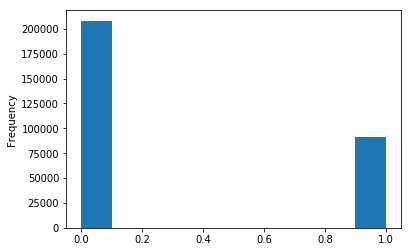

In [4]:
# plot target distribution
train_df['target'].plot.hist()

Imbalanced classification problem

### Explore NaNs

In [5]:
# difine function to explore nans
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [6]:
missing_values = missing_values_table(train_df)

Your selected dataframe has 25 columns.
There are 0 columns that have missing values.


### Check column types

In [7]:
# check column types
train_df.dtypes.value_counts()

object    17
int64      8
dtype: int64

### Check on unique values in object columns

In [8]:
# as we have categorical features let's explore unique values
train_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

bin_3        2
bin_4        2
nom_0        3
nom_1        6
nom_2        6
nom_3        6
nom_4        4
nom_5      222
nom_6      522
nom_7     1220
nom_8     2215
nom_9    11981
ord_1        5
ord_2        6
ord_3       15
ord_4       26
ord_5      192
dtype: int64

In [9]:
# explore int columns
train_df.select_dtypes('int').apply(pd.Series.nunique, axis = 0)

id        300000
bin_0          2
bin_1          2
bin_2          2
ord_0          3
day            7
month         12
target         2
dtype: int64

## Encode categorical varibles

In [10]:
# create label encoder object
le = LabelEncoder()
le_count = 0

# iterate through object columns with 2 or less unique values
for col in train_df:
    if train_df[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train_df[col].unique())) <= 2:
            # Train on the training data
            le.fit(train_df[col])
            # Transform both training and testing data
            train_df[col] = le.transform(train_df[col])
            test_df[col] = le.transform(test_df[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

2 columns were label encoded.


## Explore nom_0 - ord_5 columns

In [11]:
test_df[['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_1',
         'ord_2', 'ord_3', 'ord_4', 'ord_5']].head()

,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_1,ord_2,ord_3,ord_4,ord_5
0,Blue,Triangle,Axolotl,Finland,Piano,0870b0a5d,9ceb19dd6,530f8ecc3,9d117320c,3c49b42b8,Novice,Warm,j,P,be
1,Red,Square,Lion,Canada,Piano,a5c276589,1ad744242,12e6161c9,46ae3059c,285771075,Master,Lava Hot,l,A,RP
2,Blue,Square,Dog,China,Piano,568550f04,1fe17a1fd,27d6df03f,b759e21f0,6f323c53f,Expert,Freezing,a,G,tP
3,Red,Star,Cat,China,Piano,c5725677e,a6542cec0,30c63bd0c,0b6ec68ff,b5de3dcc4,Contributor,Lava Hot,b,Q,ke
4,Red,Trapezoid,Dog,China,Piano,e70a6270d,97b6a3518,a42386065,f91f3b1ee,967cfa9c9,Grandmaster,Lava Hot,l,W,qK


## Apply frequency encoding for nom_6 - nom9, ord_5 columns

In [12]:
# Iterate through encoded columns to get unique numerical values for test and train dfs
for col in ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_5']:
    print('Encoding', col)
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    col_encoded = temp_df[col].astype('category').cat.codes 
    temp_df[col] = col_encoded
    train_df[col] = col_encoded.iloc[:len(train_df)]
    test_df[col]  = col_encoded.iloc[len(train_df):]


Encoding nom_5
Encoding nom_6
Encoding nom_7
Encoding nom_8
Encoding nom_9
Encoding ord_5


In [13]:
# check unique values
test_df.select_dtypes('int16').apply(pd.Series.nunique, axis = 0)

nom_5      222
nom_6      522
nom_7     1219
nom_8     2214
nom_9    11839
ord_5      192
dtype: int64

### Correlations for nom_6 - nom9, ord_5 columns

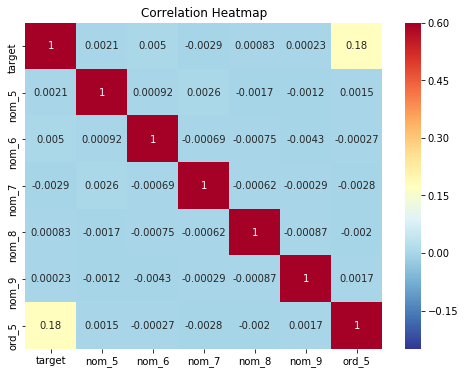

In [14]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(train_df[['target', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_5']].corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

## Label Encoding for nom_0 - nom_3, ord_1 - ord_4 columns

In [15]:
# Encode train df
le = LabelEncoder()
for col in ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'ord_1', 'ord_2', 'ord_3', 'ord_4']:
    train_df[col] = le.fit_transform(train_df[col])
    print(train_df[['target', col]].corr())

          target     nom_0
target  1.000000  0.092064
nom_0   0.092064  1.000000
          target     nom_1
target  1.000000  0.028226
nom_1   0.028226  1.000000
        target   nom_2
target  1.0000 -0.0141
nom_2  -0.0141  1.0000
          target     nom_3
target  1.000000 -0.028362
nom_3  -0.028362  1.000000
          target     nom_4
target  1.000000  0.068582
nom_4   0.068582  1.000000
          target     ord_1
target  1.000000 -0.063274
ord_1  -0.063274  1.000000
          target     ord_2
target  1.000000  0.031812
ord_2   0.031812  1.000000
          target     ord_3
target  1.000000  0.133753
ord_3   0.133753  1.000000
          target     ord_4
target  1.000000  0.160572
ord_4   0.160572  1.000000


In [16]:
le = LabelEncoder()
for col in ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'ord_1', 'ord_2', 'ord_3', 'ord_4']:
    test_df[col] = le.fit_transform(test_df[col])
    print('Encoding', col)  

Encoding nom_0
Encoding nom_1
Encoding nom_2
Encoding nom_3
Encoding nom_4
Encoding ord_1
Encoding ord_2
Encoding ord_3
Encoding ord_4


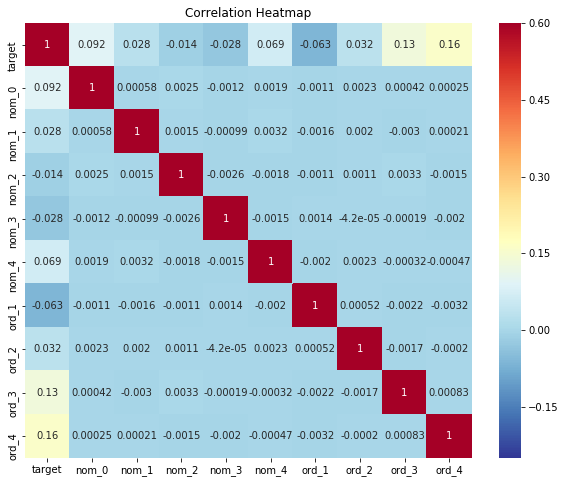

In [17]:
plt.figure(figsize = (10, 8))

# Heatmap of correlations
sns.heatmap(train_df[['target', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'ord_1', 'ord_2', 'ord_3', 
                      'ord_4']].corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [18]:
print(train_df.shape)
print(test_df.shape)

(300000, 25)
(200000, 24)


## Baseline model

### Logistic regression

In [19]:
# import logreg classifier and accuracy 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [20]:
# create train and test sets for baseline classifier
train=train_df.drop('id', axis=1).copy()
test=test_df.drop('id', axis=1).copy()

train_labels = train.pop('target')

X_train, X_test, y_train, y_test = train_test_split(train, train_labels, random_state=21,
                                                    stratify=train_labels)

In [21]:
#log_reg = LogisticRegression(C = 0.0001)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [22]:
# validation set presictions
y_pred = log_reg.predict(X_test)
# confution matrix calculation
confusion_matrix(y_test, y_pred)

array([[48140,  3919],
       [17061,  5880]])

In [23]:
# validation set probabilities
y_pred_prob = log_reg.predict_proba(X_test)[:,1]

# validation set roc auc score 
roc_auc_score(y_test, y_pred_prob)

0.7163930219269451

### Random Forest

In [24]:
# import random frorrest classifier
from sklearn.ensemble import RandomForestClassifier

In [25]:
# model with default hyperparameters
model = RandomForestClassifier()
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
# fit classifier
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
# get feature importance dataframe
features = list(train.columns)
feature_importance_vals = model.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_vals})

In [28]:
# get validation set probabilities
predictions = model.predict_proba(X_test)[:, 1]

In [29]:
# calculate roc auc score
roc_auc_score(y_test, predictions)

0.6806444025048921

#### Random Forest Feature Importance

In [30]:
# rendom forest feature importance graph
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
        """   
    # sort feature importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # normalize feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

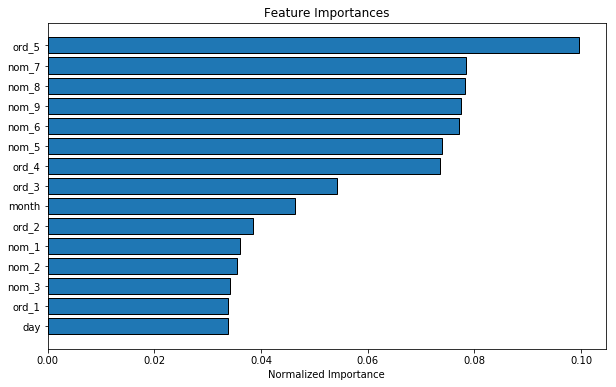

,index,feature,importance,importance_normalized
0,20,ord_5,0.099586,0.099586
1,12,nom_7,0.078455,0.078455
2,13,nom_8,0.078181,0.078181
3,14,nom_9,0.077387,0.077387
4,11,nom_6,0.077142,0.077142
5,10,nom_5,0.073858,0.073858
6,19,ord_4,0.073491,0.073491
7,18,ord_3,0.054235,0.054235
8,22,month,0.046377,0.046377
9,17,ord_2,0.038549,0.038549


In [31]:
plot_feature_importances(feature_importances)

## Feature engeneering 2

In [32]:
# df copies
train_df_2 = train_df.copy()
test_df_2 = test_df.copy()

In [33]:
# check unique values 
test_df_2[test_df_2.columns].nunique()

id       200000
bin_0         2
bin_1         2
bin_2         2
bin_3         2
bin_4         2
nom_0         3
nom_1         6
nom_2         6
nom_3         6
nom_4         4
nom_5       222
nom_6       522
nom_7      1219
nom_8      2214
nom_9     11839
ord_0         3
ord_1         5
ord_2         6
ord_3        15
ord_4        26
ord_5       192
day           7
month        12
dtype: int64

### Cyclical Features

In [34]:
# create cyclical features for day and month
train_df_2['hr_sin'] = np.sin((train_df_2.day-1)*(2.*np.pi/7))
train_df_2['hr_cos'] = np.cos((train_df_2.day-1)*(2.*np.pi/7))
train_df_2['mnth_sin'] = np.sin((train_df_2.month-1)*(2.*np.pi/12))
train_df_2['mnth_cos'] = np.cos((train_df_2.month-1)*(2.*np.pi/12))

In [35]:
# create cyclical features for day and month (test data)
test_df_2['hr_sin'] = np.sin((test_df_2.day-1)*(2.*np.pi/7))
test_df_2['hr_cos'] = np.cos((test_df_2.day-1)*(2.*np.pi/7))
test_df_2['mnth_sin'] = np.sin((test_df_2.month-1)*(2.*np.pi/12))
test_df_2['mnth_cos'] = np.cos((test_df_2.month-1)*(2.*np.pi/12))

### One-hot encoding

In [36]:
# one hot encoding train data set
for col in ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'ord_1', 'ord_2', 'ord_3', 'day', 'month']:
    print('Encoding', col)
    encoded_columns = pd.get_dummies(train_df_2[col], prefix=col)
    train_df_2 = train_df_2.join(encoded_columns.iloc[:, :-1]).drop(col, axis=1)




Encoding nom_0
Encoding nom_1
Encoding nom_2
Encoding nom_3
Encoding nom_4
Encoding ord_1
Encoding ord_2
Encoding ord_3
Encoding day
Encoding month


In [37]:
# one hot encoding test data set
for col in ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'ord_1', 'ord_2', 'ord_3', 'day', 'month']:
    print('Encoding', col)
    encoded_columns = pd.get_dummies(test_df_2[col], prefix=col)
    test_df_2 = test_df_2.join(encoded_columns.iloc[:, :-1]).drop(col, axis=1)

Encoding nom_0
Encoding nom_1
Encoding nom_2
Encoding nom_3
Encoding nom_4
Encoding ord_1
Encoding ord_2
Encoding ord_3
Encoding day
Encoding month


In [38]:
# check data shape
print(train_df_2.shape)
print(test_df_2.shape)

(300000, 79)
(200000, 78)


### Target encoding

In [39]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [40]:
# Target encoding
for col in ['nom_9', 'nom_8', 'nom_7', 'nom_6', 'nom_5']:
    print('Encoding', col)
    trn, sub = target_encode(train_df_2[col], 
                         test_df_2[col], 
                         target=train_df_2.target, 
                         min_samples_leaf=100,
                         smoothing=10,
                         noise_level=0.009)
    train_df_2[col] = trn
    test_df_2[col] = sub

Encoding nom_9
Encoding nom_8
Encoding nom_7
Encoding nom_6
Encoding nom_5


In [41]:
# Target encoding for ord_4 and ord_5
for col in ['ord_4', 'ord_5']:
    print('Encoding', col)
    trn, sub = target_encode(train_df_2[col], 
                         test_df_2[col], 
                         target=train_df_2.target, 
                         min_samples_leaf=100,
                         smoothing=5,
                         noise_level=0.005)
    train_df_2[col] = trn
    test_df_2[col] = sub

Encoding ord_4
Encoding ord_5


In [42]:
print(train_df_2.shape)
print(test_df_2.shape)

(300000, 79)
(200000, 78)


In [43]:
train_df_2.tail()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
299995,299995,0,0,0,1,0,0.330203,0.227428,0.308616,0.298719,...,0,0,0,0,0,0,1,0,0,0
299996,299996,0,0,0,0,1,0.364591,0.415531,0.229927,0.284880,...,1,0,0,0,0,0,0,0,0,0
299997,299997,0,0,0,0,1,0.344635,0.343619,0.309921,0.334261,...,0,0,0,0,0,0,0,1,0,0
299998,299998,0,1,0,0,1,0.311347,0.298767,0.358000,0.280558,...,0,0,0,0,0,0,1,0,0,0
299999,299999,0,0,0,0,1,0.334132,0.340450,0.234025,0.309456,...,0,1,0,0,0,0,0,0,0,0


## Models

### Logistic regression

In [44]:
# create new train/test sets
train=train_df_2.drop(['id'], axis=1).copy()
test=test_df_2.drop('id', axis=1).copy()

train_labels = train.pop('target')

X_train, X_test, y_train, y_test = train_test_split(train, train_labels, random_state=21,
                                                    stratify=train_labels)

In [45]:
# apply logistinc regression
log_reg = LogisticRegression(C=1000, random_state=21)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=21, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [46]:
# predict test values
y_pred = log_reg.predict(X_test)

In [47]:
# create confusion matrix
confusion_matrix(y_test, y_pred)

array([[46585,  5474],
       [11903, 11038]])

In [48]:
# create test probabilities
y_pred_prob = log_reg.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_prob)

0.8094524203973037

### Random Forest

In [49]:
# model with default hyperparameters
model = RandomForestClassifier()

In [50]:
model.fit(X_train, y_train)
features = list(train.columns)
feature_importance_vals = model.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_vals})
predictions = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, predictions)

0.7122600232248149

### Grid search

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [52]:
param_dist = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1200] }
log_reg = LogisticRegression()
clf = GridSearchCV(log_reg, param_dist, cv = 4, n_jobs=-1)
best_clf = clf.fit(X_train, y_train)

In [53]:
y_pred_prob = best_clf.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_prob)

0.8094524203973037

In [54]:
best_clf.best_params_

{'C': 1000}

### LogReg cross validtion

In [55]:
from sklearn.linear_model import LogisticRegressionCV

In [70]:
clf = LogisticRegressionCV(Cs=1000, cv=4, random_state=21, multi_class='auto', max_iter=200)
clf

LogisticRegressionCV(Cs=1000, class_weight=None, cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=200,
           multi_class='auto', n_jobs=None, penalty='l2', random_state=21,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [60]:
clf.fit(X_train, y_train)

LogisticRegressionCV(Cs=1000, class_weight=None, cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=200,
           multi_class='auto', n_jobs=None, penalty='l2', random_state=21,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [61]:
y_pred_prob = clf.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred_prob)

0.809454433316293

## Submission file

In [63]:
# submit csv
valid_df = clf.predict_proba(test)[:,1]

submission = pd.DataFrame(test_df['id'])

submission['target'] = valid_df

submission.to_csv('/Users/alex/Documents/cat-in-the-dat/submission20093.csv', index=False)